#Imports

In [ ]:
%pip install python-pptx
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor
import datetime
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import math
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
from scipy.stats import pearsonr,f_oneway
from google.colab import drive
import sys
import matplotlib as mpl
import matplotlib.font_manager as fm
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive', force_remount = True)

## Dan
root_path = f"/content/drive/MyDrive/Master/Projects/Fungi_Cancer (Thomy Margalit)"
code_path = f'{root_path}/project'
res_path = f'{root_path}/results'

drive.mount("/content/drive", force_remount=True)

# Thomy
#root_path = "/content/drive/MyDrive/"
#code_path = "/content/drive/MyDrive/files_for_fungi_analysis/code/fungi_cancer"
#res_path = f'{root_path}/files_for_fungi_analysis/results'


sys.path.append(code_path)

import iptw
import utils
import plotting
import load_data

Mounted at /content/drive
Mounted at /content/drive


#Reading the data:

In [ ]:
specimen_type = 'RNA-Seq' #"RNA-Seq" #'WGS
cohort_definition = 'iptw'
dataframes, overlap_dataframes = load_data.read_flow(root_path)
raw_fungi_for_analysis, raw_fungi_for_bc = load_data.raw_fungi_for_analysis(dataframes,specimen_type)
#plotting.bar_plot_by_race_analysiscohort(raw_fungi_for_analysis)
raw_fungi_for_analysis.set_index("Sample")
raw_fungi_for_analysis.to_csv(f'{res_path}/raw_fungi_for_analysis_{specimen_type}.csv')
raw_fungi_for_bc.to_csv(f'{res_path}/raw_fungi_for_bc_{specimen_type}.csv')

Only Primary Tumor Samples: 10997
Only RNA-Seq Samples: 8992
Samples with all clinical variables: 5002


In [ ]:
drive.mount("/content/drive", force_remount=True)

nh22_fungi_merged_copy = dataframes["poore_2022_raw_fungi_counts_merged"].copy()
nh22_fungi_merged_copy = nh22_fungi_merged_copy[nh22_fungi_merged_copy["sample_type"] =="Primary Tumor"]
nh22_fungi_merged_copy = nh22_fungi_merged_copy[nh22_fungi_merged_copy["experimental_strategy"] == "RNA-Seq"]
nh22_fungi_merged_copy = raw_fungi_for_analysis.copy()
nh22_fungi_merged_copy = load_data.add_bmi_and_obesity_cols(nh22_fungi_merged_copy, dataframes)

nh22_fungi_merged_copy = utils.add_bmi_and_age_groups(nh22_fungi_merged_copy)
utils.create_conf_and_vars_xlsx(nh22_fungi_merged_copy,res_path)


Mounted at /content/drive


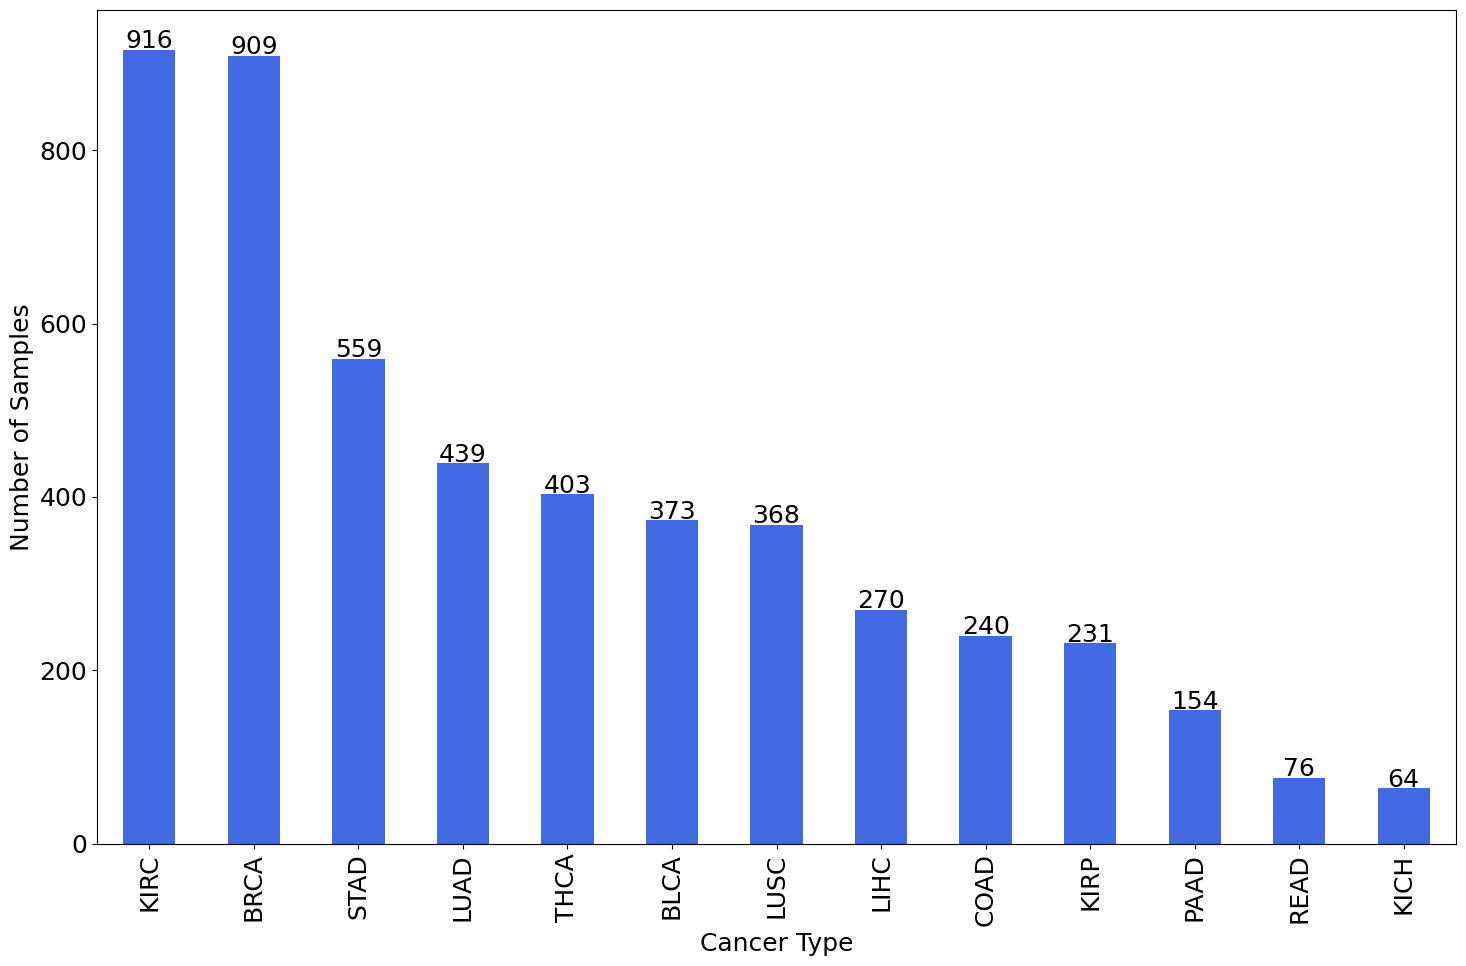

In [ ]:
plotting.bar_plot_by_cancer(raw_fungi_for_analysis,res_path)

In [ ]:
# @title
len(list(set(dataframes['bacteria_counts_salzberg'].columns[1:]).intersection(dataframes['poore_2022_wisoverlap'].columns[1:])))

salz_and_poore_2022_same_filenames = set(dataframes['poore_2022_wisoverlap_merged']['filename']).intersection(dataframes['salzberg_merged']['filename'])
len(salz_and_poore_2022_same_filenames)
len(overlap_dataframes['poore_2022_wisoverlap_merged'])

716

#Vlidation of NH22 data (comparison of NH22 vs. G23, and P20 vs. G23)


## Data preprocessing




In [ ]:
#extract overlapp
poore_2022_wisoverlap_merged_sampesamples_sametaxa = overlap_dataframes["poore_2022_wisoverlap_merged"]
salzberg_merged_samesamples_sametaxa = overlap_dataframes["salzberg_merged"]
poore_2020_merged_sampesamples_sametaxa = overlap_dataframes["poore_2020_merged"]
all_together_same_taxa = load_data.get_overlapping_taxa(dataframes)

#add mean_per_patient columon
poore_2020_merged_sampesamples_sametaxa["mean_per_patient"] = poore_2020_merged_sampesamples_sametaxa.iloc[:,1:-43].mean(axis = 1)
poore_2022_wisoverlap_merged_sampesamples_sametaxa["mean_per_patient"] = poore_2022_wisoverlap_merged_sampesamples_sametaxa.iloc[:,1:-43].mean(axis = 1)
salzberg_merged_samesamples_sametaxa["mean_per_patient"] = salzberg_merged_samesamples_sametaxa.iloc[:,1:-43].mean(axis = 1)

#add total count columon
poore_2020_merged_sampesamples_sametaxa["total_counts"] = poore_2020_merged_sampesamples_sametaxa.iloc[:,1:-44].sum(axis = 1)
poore_2022_wisoverlap_merged_sampesamples_sametaxa["total_counts"] = poore_2022_wisoverlap_merged_sampesamples_sametaxa.iloc[:,1:-44].sum(axis = 1)
salzberg_merged_samesamples_sametaxa["total_counts"] = salzberg_merged_samesamples_sametaxa.iloc[:,1:-44].sum(axis = 1)

#why is that? What about poore 2020, why it was missing?
salzberg_merged_samesamples_sametaxa = salzberg_merged_samesamples_sametaxa.set_index('filename').sort_index()
poore_2022_wisoverlap_merged_sampesamples_sametaxa = poore_2022_wisoverlap_merged_sampesamples_sametaxa.set_index('filename').sort_index()
poore_2020_merged_sampesamples_sametaxa = poore_2020_merged_sampesamples_sametaxa.set_index('filename').sort_index()

print(poore_2020_merged_sampesamples_sametaxa.iloc[:,1:-45].shape[0])
print(poore_2020_merged_sampesamples_sametaxa.iloc[:,1:-45].shape[1])
print(poore_2020_merged_sampesamples_sametaxa.investigation.value_counts())

716
153
investigation
TCGA-HNSC    330
TCGA-BRCA    232
TCGA-BLCA    154
Name: count, dtype: int64


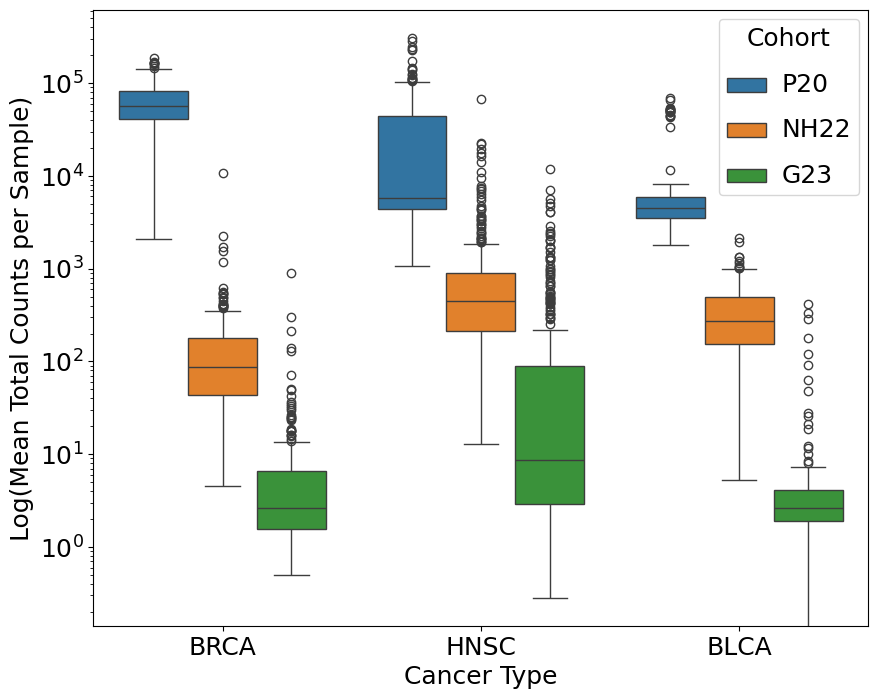

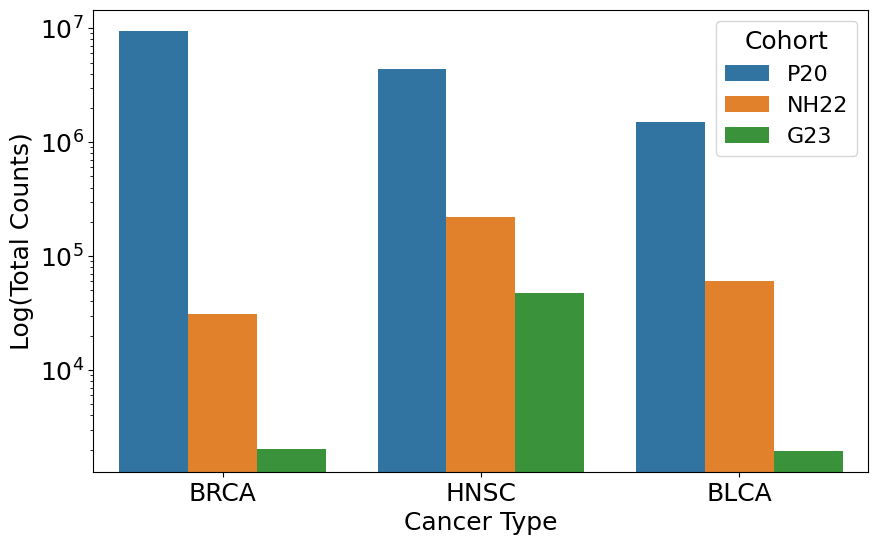

In [ ]:
plotting.mean_total_count_per_sample(poore_2020_merged_sampesamples_sametaxa,poore_2022_wisoverlap_merged_sampesamples_sametaxa,salzberg_merged_samesamples_sametaxa,res_path)
plotting.total_count_per_cancer_type(poore_2020_merged_sampesamples_sametaxa,poore_2022_wisoverlap_merged_sampesamples_sametaxa,salzberg_merged_samesamples_sametaxa,res_path)

In [ ]:
# Get the summed counts for each dataset
summed_counts_poore_2022 = utils.sum_counts(poore_2022_wisoverlap_merged_sampesamples_sametaxa, all_together_same_taxa, 'NH22')
summed_counts_salzberg = utils.sum_counts(salzberg_merged_samesamples_sametaxa, all_together_same_taxa, 'G23')
summed_counts_poore_2020 = utils.sum_counts(poore_2020_merged_sampesamples_sametaxa, all_together_same_taxa, 'P20')

# Create a DataFrame
resulting_df_allcancers = pd.DataFrame([summed_counts_poore_2022, summed_counts_salzberg, summed_counts_poore_2020]).transpose()

# Sum counts by cancer type for each dataset
df_poore_2022 = utils.sum_counts_by_cancer(poore_2022_wisoverlap_merged_sampesamples_sametaxa, all_together_same_taxa, 'NH22')
df_salzberg = utils.sum_counts_by_cancer(salzberg_merged_samesamples_sametaxa, all_together_same_taxa, 'G23')
df_poore_2020 = utils.sum_counts_by_cancer(poore_2020_merged_sampesamples_sametaxa, all_together_same_taxa, 'P20')

# Combine DataFrames
resulting_df_bycancer = pd.concat([df_poore_2022, df_salzberg, df_poore_2020])
resulting_df_bycancer = resulting_df_bycancer.reorder_levels(['Dataset', 'investigation']).sort_index()

#Create color dictionary:
unique_cancers = resulting_df_bycancer.index.get_level_values('investigation').unique()
cmap = plt.get_cmap('tab10')
colors = {cancer: cmap(i) for i, cancer in enumerate(unique_cancers)}

resulting_df_bycancer_flat = resulting_df_bycancer.reset_index()

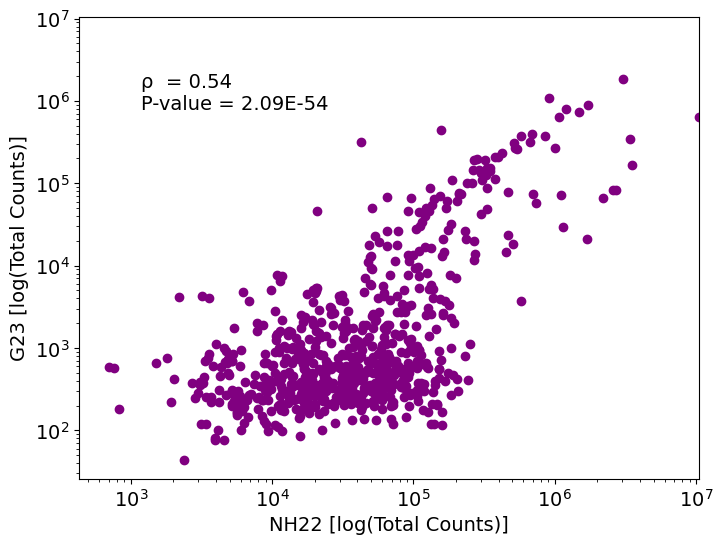

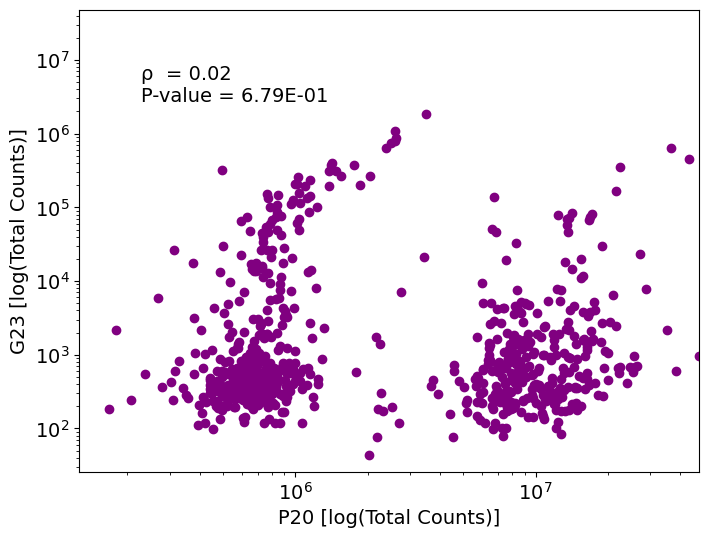

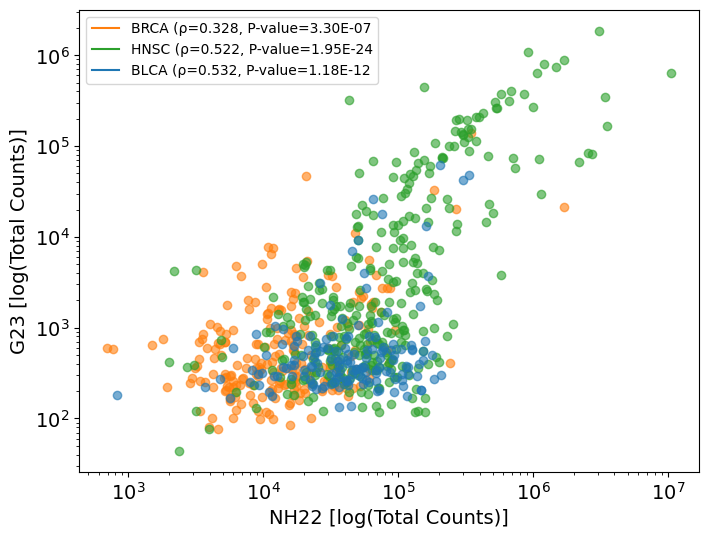

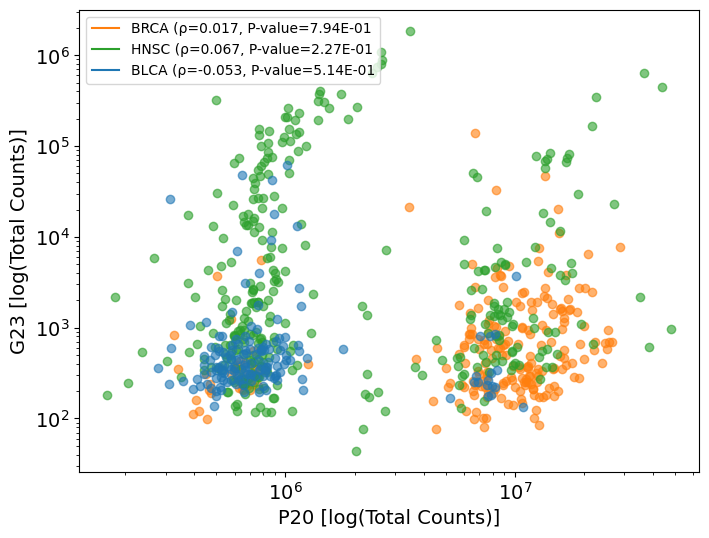

In [ ]:
total_count_data = pd.melt(pd.concat([
    poore_2020_merged_sampesamples_sametaxa[['investigation', 'total_counts']].assign(dataset='P20'),
    poore_2022_wisoverlap_merged_sampesamples_sametaxa[['investigation', 'total_counts']].assign(dataset='NH22'),
    salzberg_merged_samesamples_sametaxa[['investigation', 'total_counts']].assign(dataset='G23')
]), id_vars=['investigation', 'dataset'], value_vars=['total_counts'], value_name='value')

plotting.scatter_totalcounts_per_sample(total_count_data, 'NH22','G23')
plotting.scatter_totalcounts_per_sample(total_count_data, 'P20','G23')

plotting.scatter_totalcounts_per_sample_per_cancer(total_count_data,  'NH22','G23',colors)
plotting.scatter_totalcounts_per_sample_per_cancer(total_count_data,  'P20','G23',colors)

list of species that were removed because their total count was zero: ['Sphaerobacter']


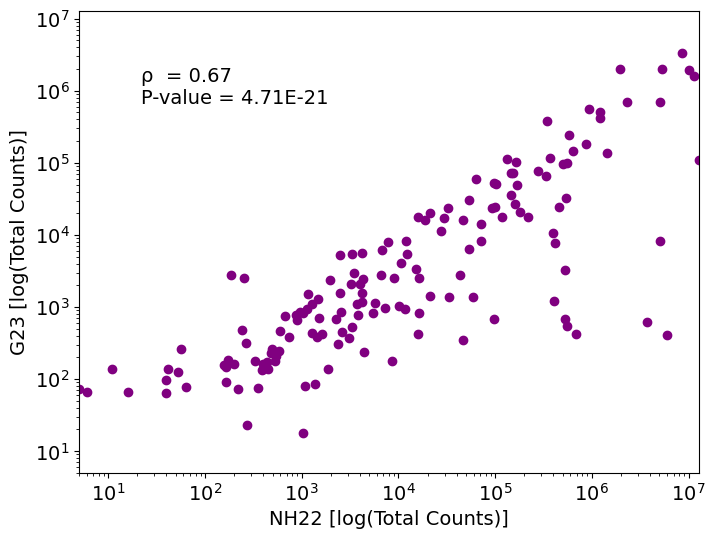

list of species that were removed because their total count was zero: []


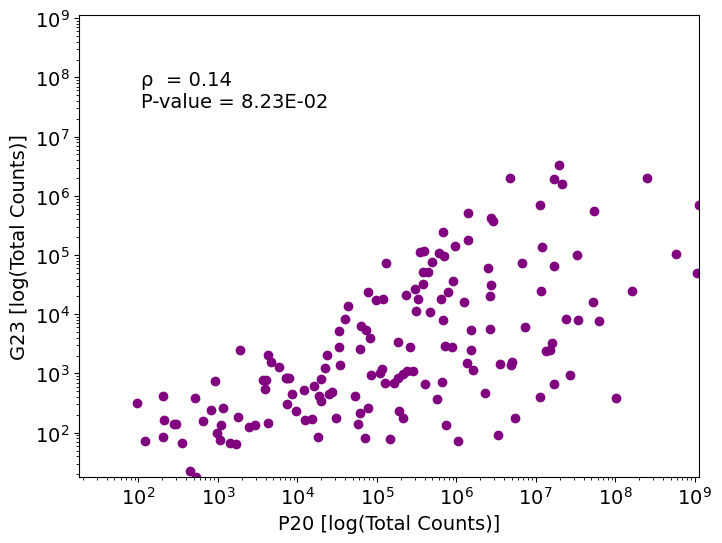

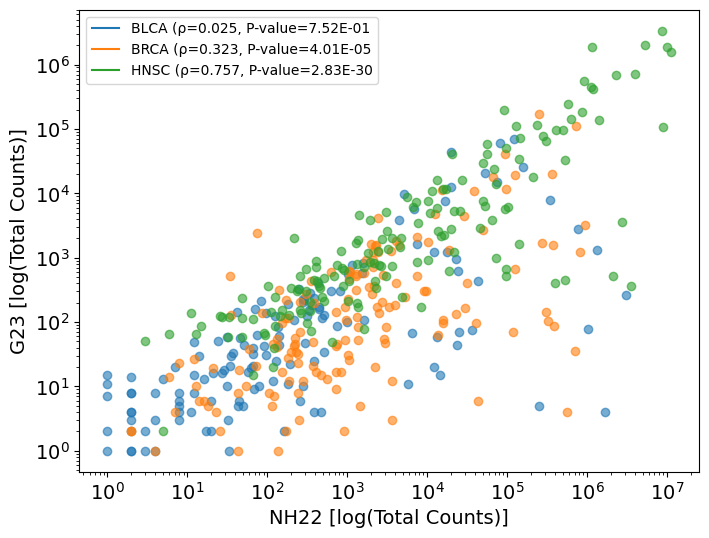

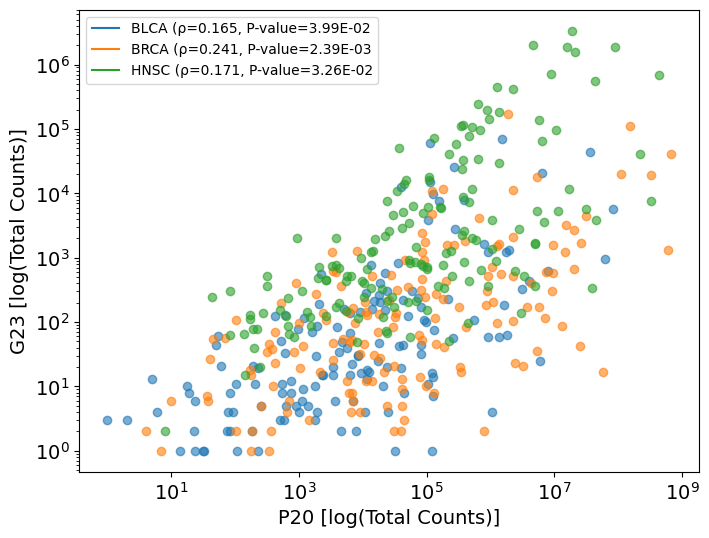

In [ ]:
plotting.scatter_totalcounts(resulting_df_allcancers, 'NH22', 'G23')
plotting.scatter_totalcounts(resulting_df_allcancers, 'P20', 'G23')

plotting.scatter_totalcounts_per_cancer(resulting_df_bycancer_flat, colors, 'NH22', 'G23')
plotting.scatter_totalcounts_per_cancer(resulting_df_bycancer_flat, colors, 'P20', 'G23')

In [ ]:
# @title
print("epsilon = 0.1 v2 scatterplot")
scatter_totalcounts_v2(resulting_df_allcancers, epsilon = 0.1)
print("epsilon = 0.001 v2 scatterplot")
scatter_totalcounts_v2(resulting_df_allcancers, epsilon = 0.1)


In [ ]:
# @title
# Compute Ratios + Plot the Ratios
ratios_df_NH22_G23 = utils.compute_ratios(resulting_df_allcancers,'NH22', 'G23')
plotting.plot_ratios(ratios_df_NH22_G23,'NH22', 'G23')

ratios_df_P20_G23 = utils.compute_ratios(resulting_df_allcancers,'P20', 'G23')
plotting.plot_ratios(ratios_df_P20_G23,'P20', 'G23')

In [ ]:
# @title
## Taking only half of the ratio (x_1/x_2) ###
side_type=True
ratios_df = utils.compute_ratios_filtered(resulting_df_allcancers,'NH22', 'G23',side_type)
plotting.plot_ratios(ratios_df,'NH22', 'G23')

ratios_df = utils.compute_ratios_filtered(resulting_df_allcancers,'P20', 'G23',side_type)
plotting.plot_ratios(ratios_df,'P20', 'G23')

## Taking only half of the ratio (x_2/x_1) ###
side_type=False
ratios_df = utils.compute_ratios_filtered(resulting_df_allcancers,'NH22', 'G23',side_type)
plotting.plot_ratios(ratios_df,'NH22', 'G23')

ratios_df = utils.compute_ratios_filtered(resulting_df_allcancers,'P20', 'G23',side_type)
plotting.plot_ratios(ratios_df,'P20', 'G23')

list of species that were removed because their total count was zero: []
list of species that were removed because their total count was zero: ['Sphaerobacter/Rheinheimera', 'Sphaerobacter/Streptococcus', 'Sphaerobacter/Dialister', 'Sphaerobacter/Modestobacter', 'Sphaerobacter/Anaerostipes', 'Sphaerobacter/Finegoldia', 'Sphaerobacter/Chryseobacterium', 'Sphaerobacter/Fusobacterium', 'Sphaerobacter/Oscillibacter', 'Sphaerobacter/Selenomonas', 'Sphaerobacter/Staphylococcus', 'Sphaerobacter/Propionibacterium', 'Sphaerobacter/Achromobacter', 'Sphaerobacter/Tannerella', 'Sphaerobacter/Geobacillus', 'Sphaerobacter/Lactococcus', 'Sphaerobacter/Clostridium', 'Sphaerobacter/Aggregatibacter', 'Sphaerobacter/Alcanivorax', 'Sphaerobacter/Desulfovibrio', 'Sphaerobacter/Anaerococcus', 'Sphaerobacter/Corynebacterium', 'Sphaerobacter/Myroides', 'Sphaerobacter/Lactobacillus', 'Sphaerobacter/Sphingobium', 'Sphaerobacter/Cardiobacterium', 'Sphaerobacter/Gardnerella', 'Sphaerobacter/Enterococcus', 'Sphaer

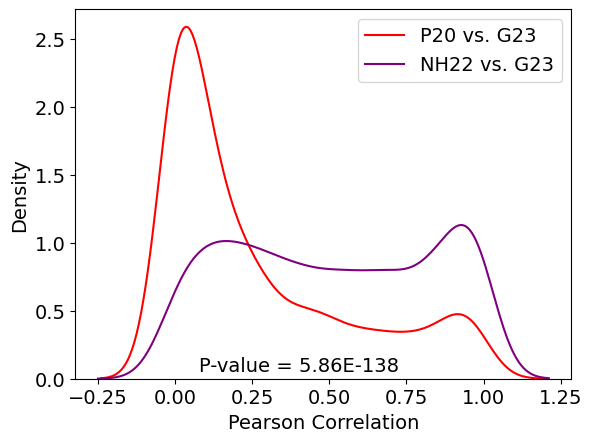

In [ ]:
n_iterations = 2000
ratios_df_P20_G23 = utils.compute_ratios(resulting_df_allcancers,'P20', 'G23')
ratios_df_NH22_G23 = utils.compute_ratios(resulting_df_allcancers,'NH22', 'G23')

list_corr_NH22_G23,list_corr_P20_G23 = utils.calc_indepedent_correlations(resulting_df_allcancers,ratios_df_NH22_G23, 'NH22', 'G23',ratios_df_P20_G23, 'P20', 'G23', n_iterations)
#list_corr_NH22_G23,list_corr_P20_G23 = calc_indepedent_correlations(resulting_df_allcancers,ratios_df_NH22_G23, 'NH22', 'G23',ratios_df_P20_G23, 'P20', 'G23', n_iterations)

print('Mean:',np.mean(list_corr_P20_G23), ',STD:', np.std(list_corr_P20_G23))
print('Mean:',np.mean(list_corr_NH22_G23), ',STD:', np.std(list_corr_NH22_G23))

plotting.pearson_ind_corellations(list_corr_P20_G23, list_corr_NH22_G23)

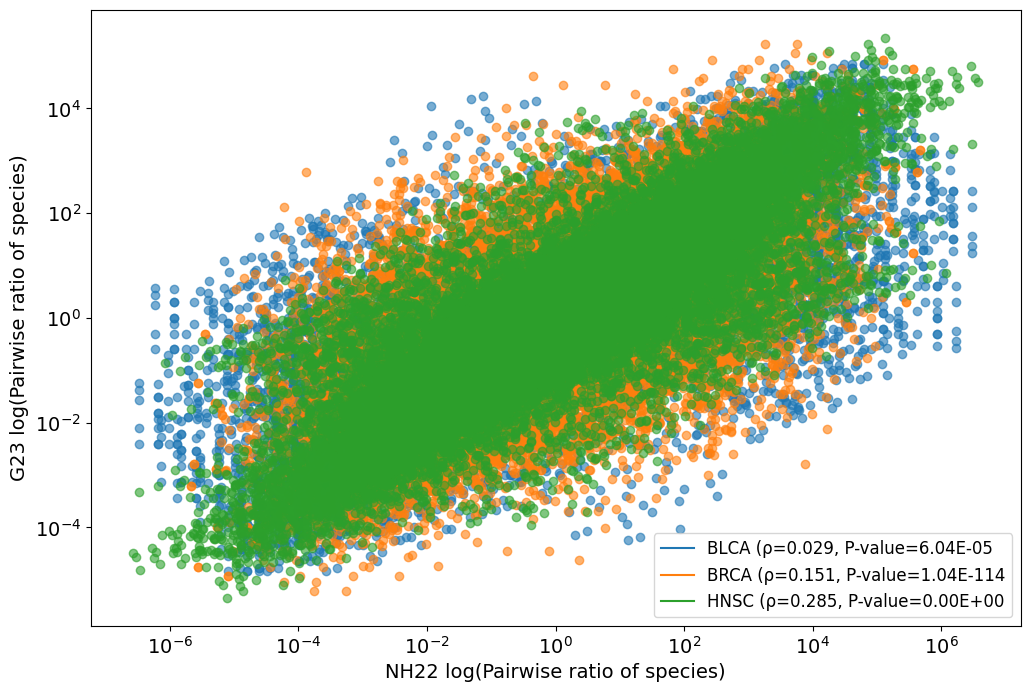

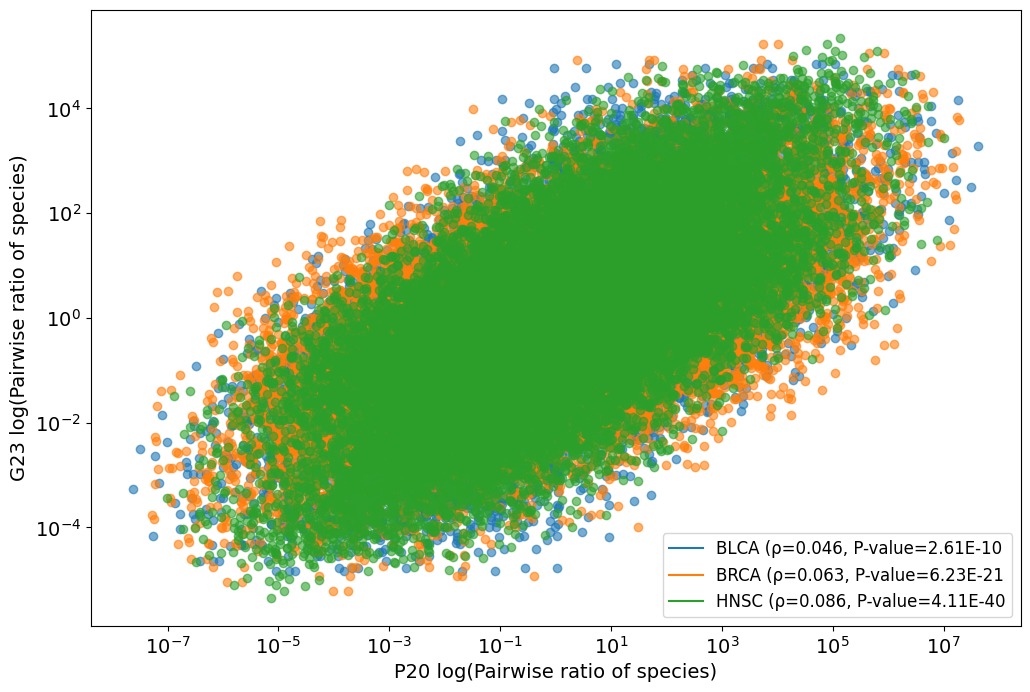

In [ ]:
# Calculate the ratios
fungus_columns = all_together_same_taxa
poore_ratios_df = utils.compute_ratios_by_cancer(resulting_df_bycancer, "NH22",fungus_columns)
salz_ratios_df = utils.compute_ratios_by_cancer(resulting_df_bycancer,"G23", fungus_columns)
poore_2020_ratios_df = utils.compute_ratios_by_cancer(resulting_df_bycancer,"P20", fungus_columns)

merged_ratios = poore_ratios_df.merge(salz_ratios_df, on=['Cancer', 'Pair'], suffixes=('_NH22', '_G23'))
merged_ratios = merged_ratios.merge(poore_2020_ratios_df, on=['Cancer', 'Pair']).rename(columns={"Ratio": "Ratio_P20"})

plotting.plot_ratios_bycancer_v2(merged_ratios, colors,'NH22', 'G23')
plotting.plot_ratios_bycancer_v2(merged_ratios, colors,'P20', 'G23')

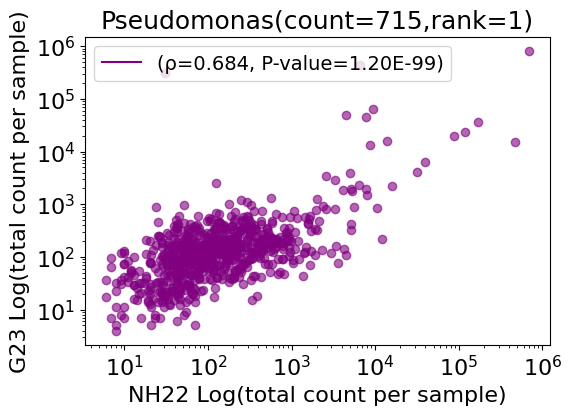

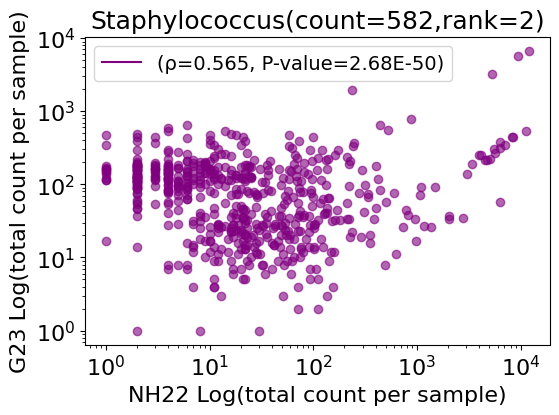

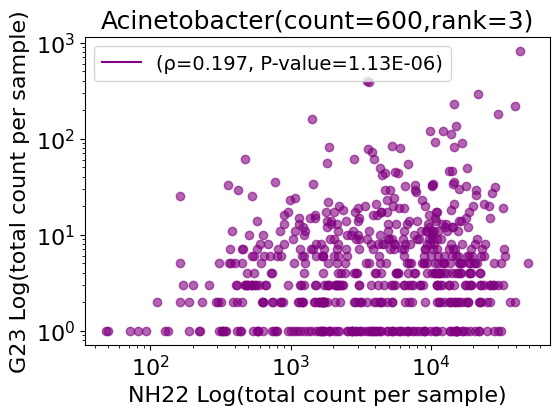

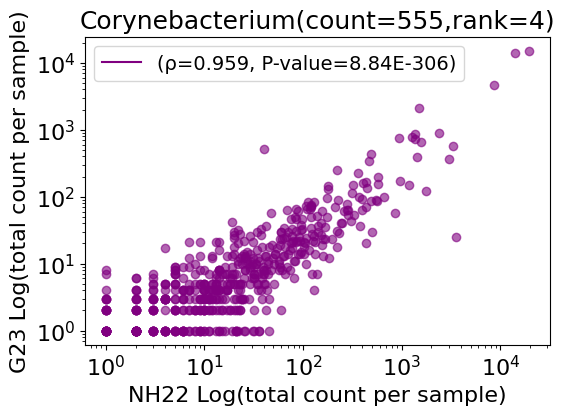

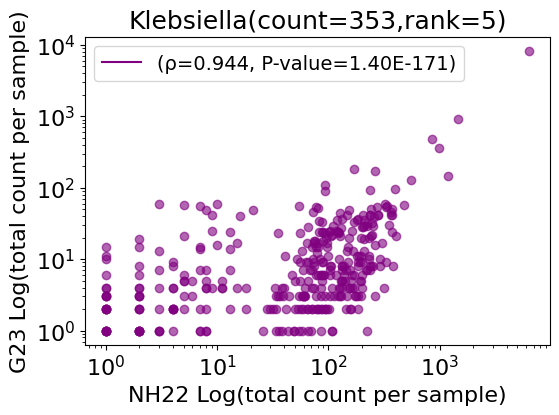

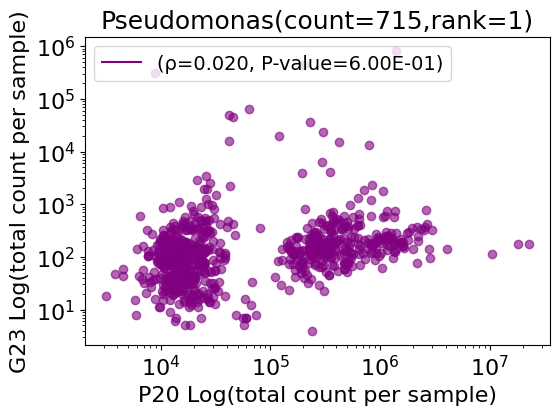

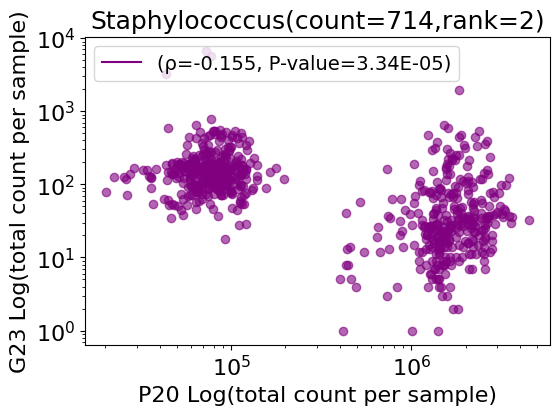

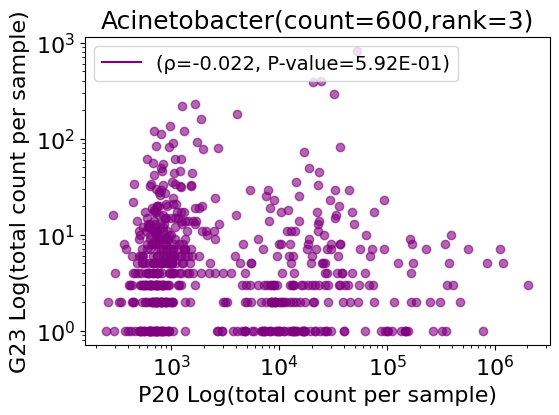

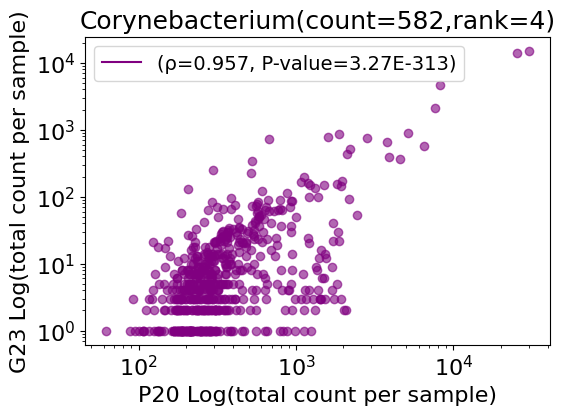

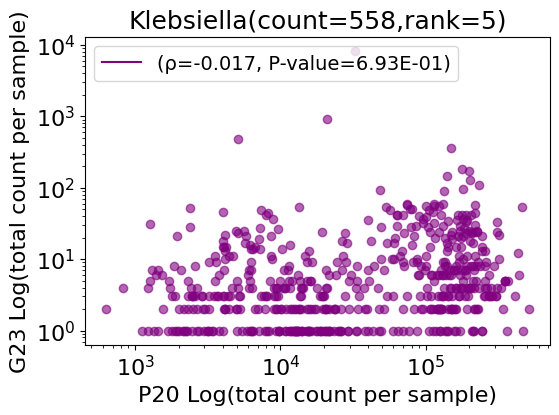

TCGA-BRCA


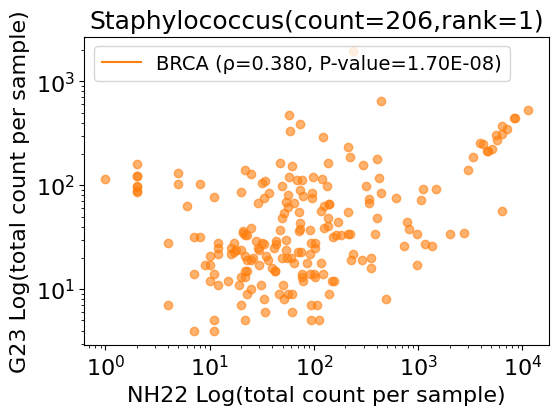

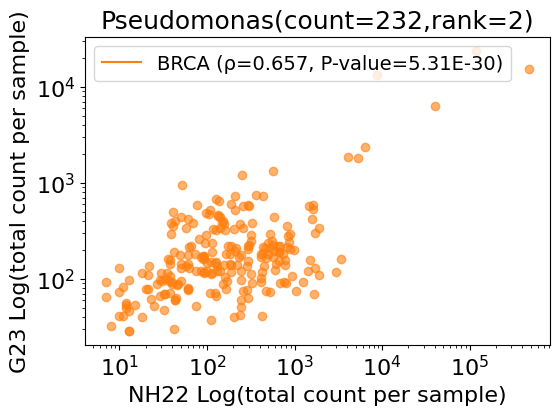

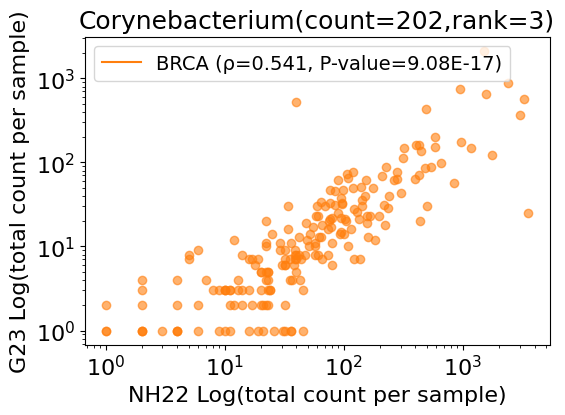

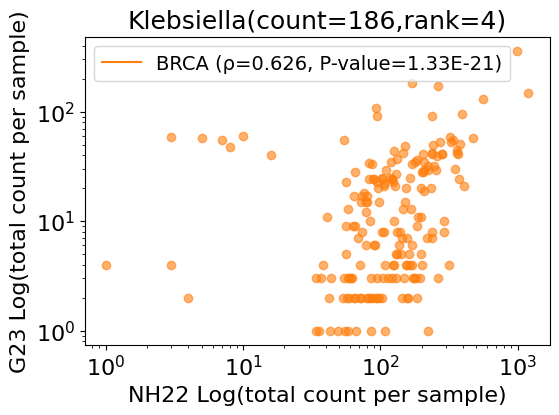

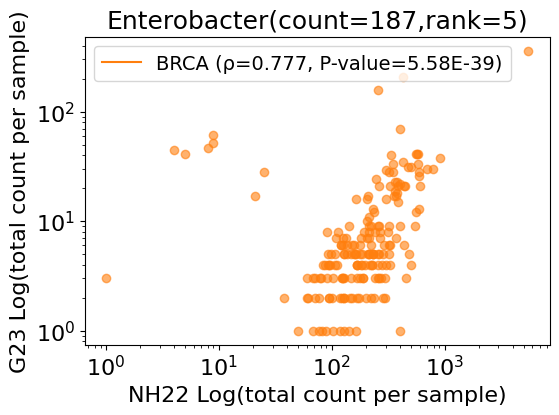

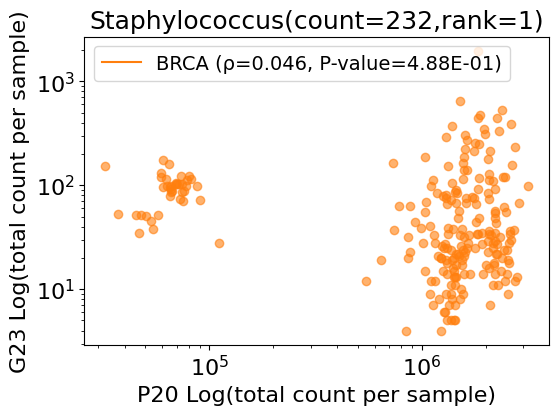

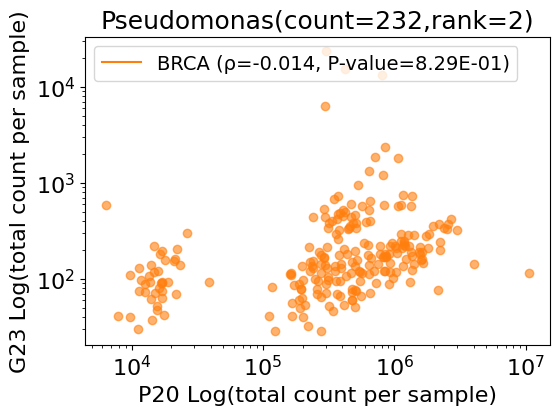

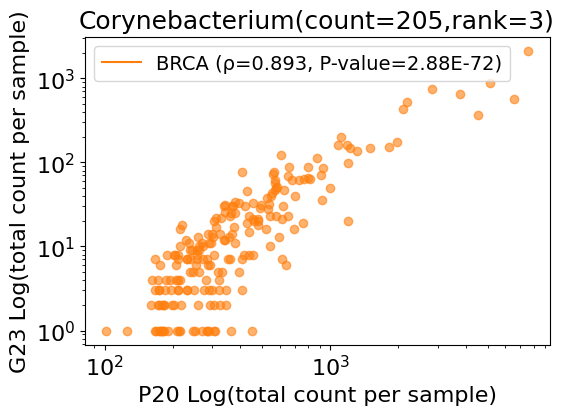

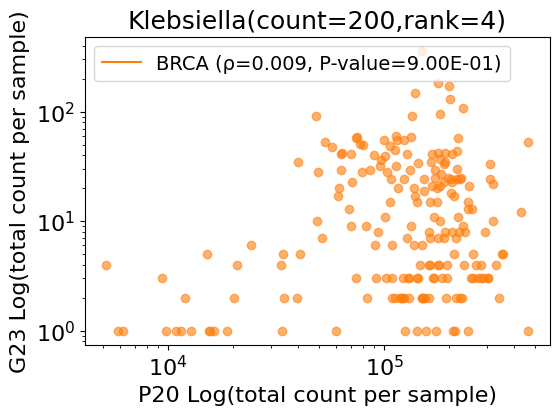

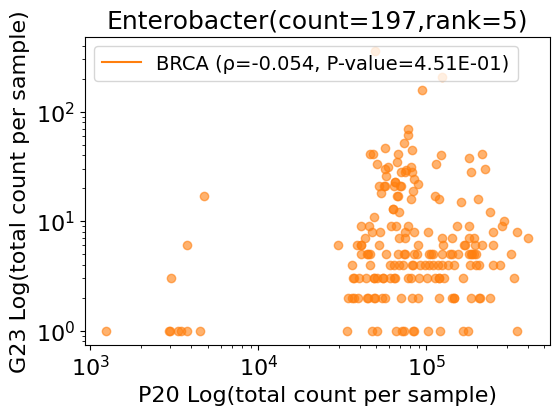

TCGA-HNSC


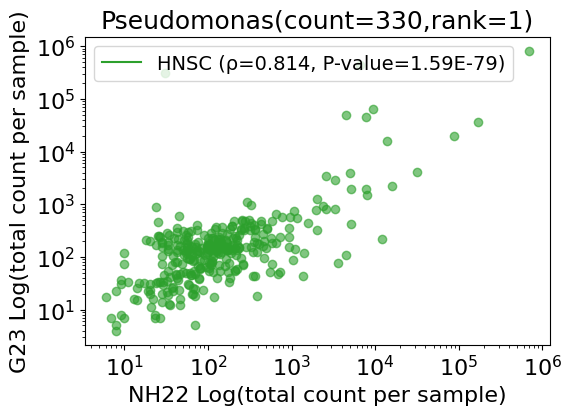

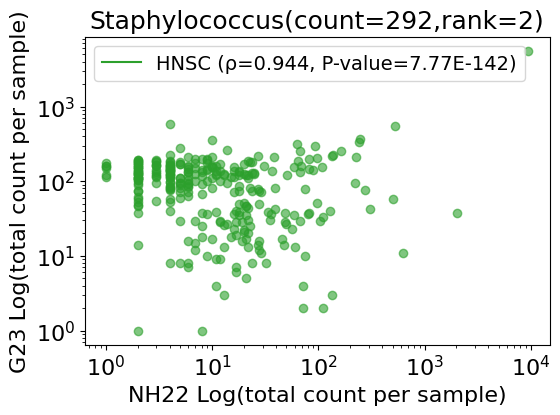

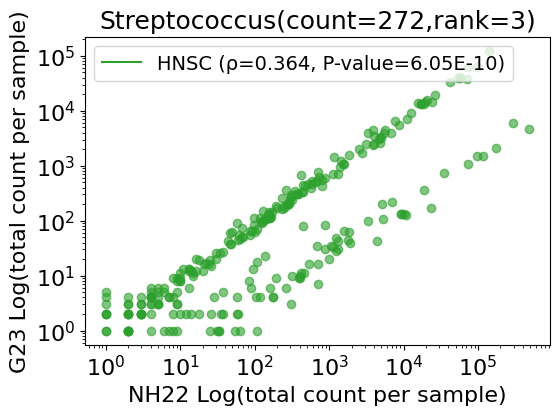

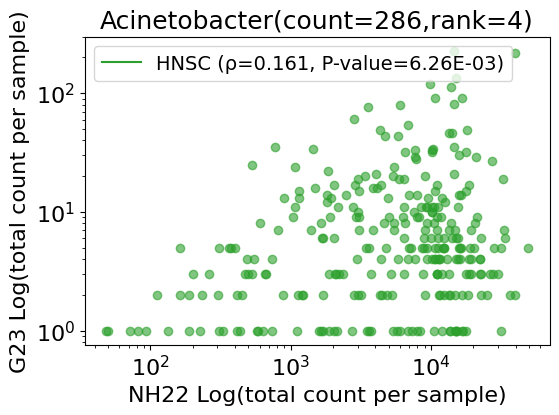

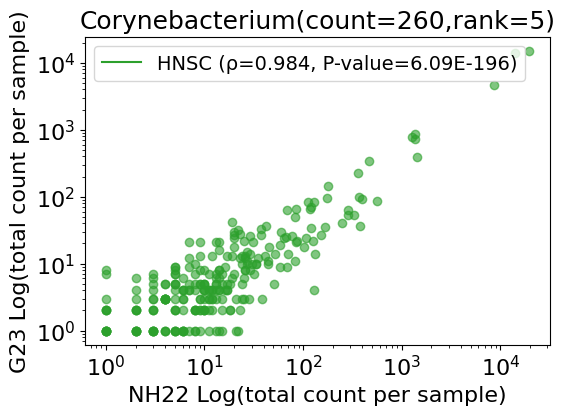

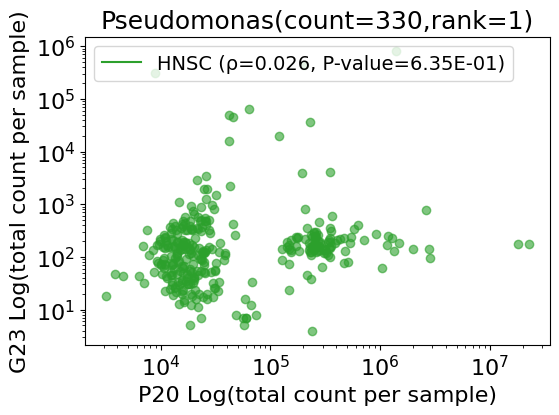

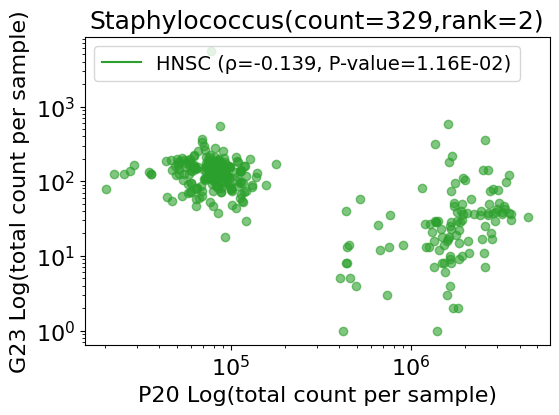

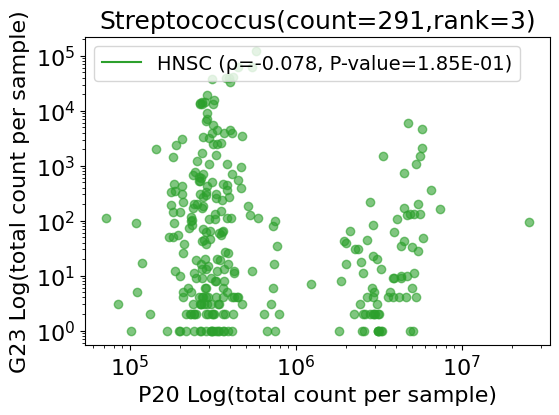

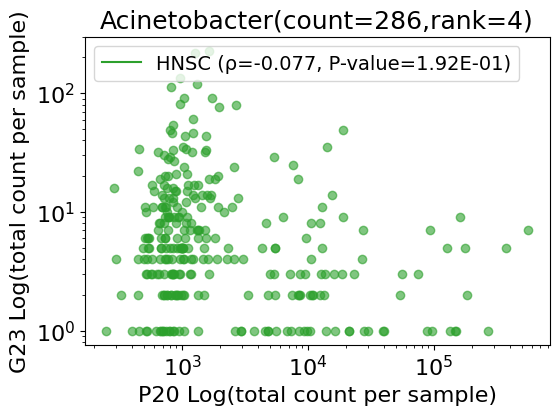

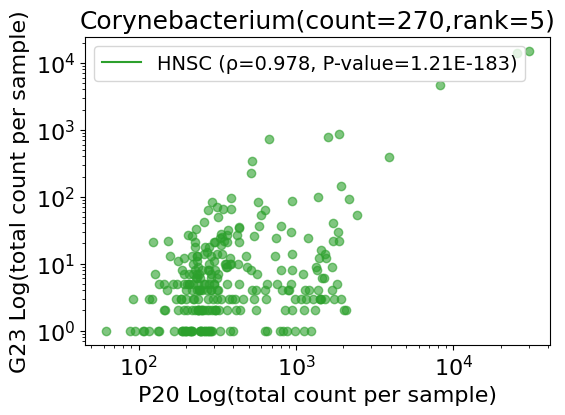

TCGA-BLCA


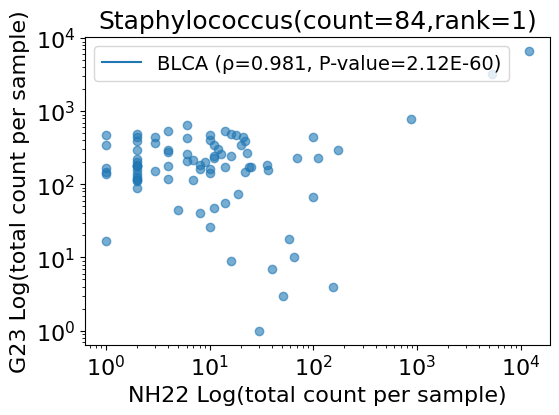

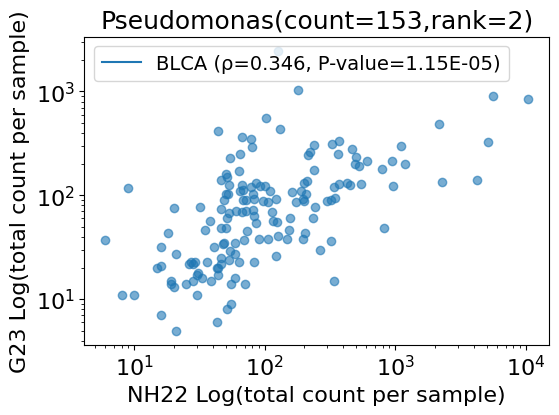

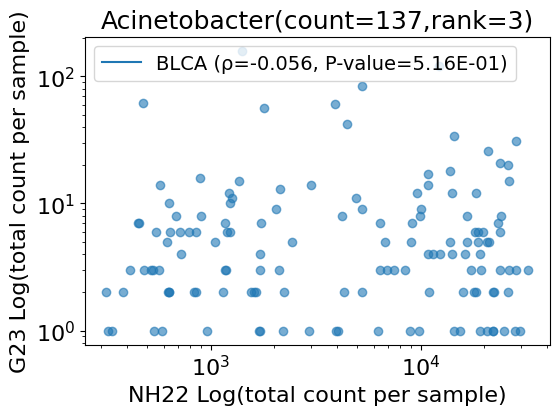

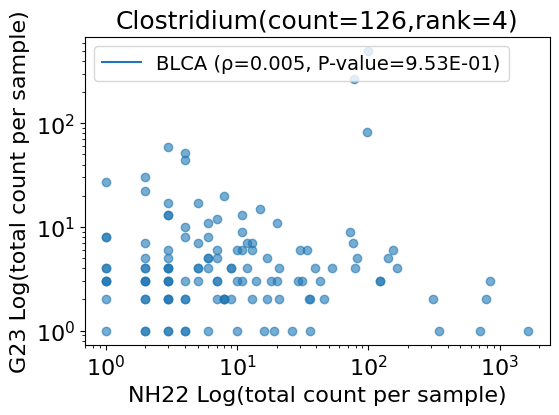

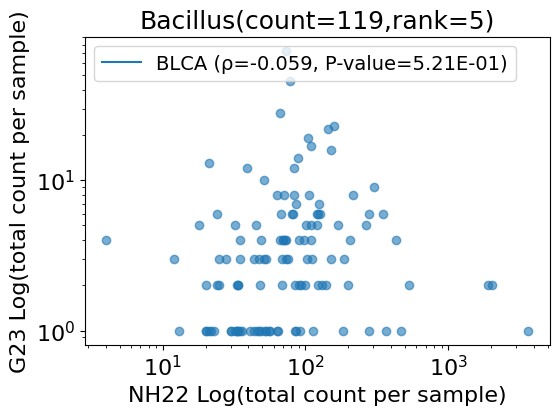

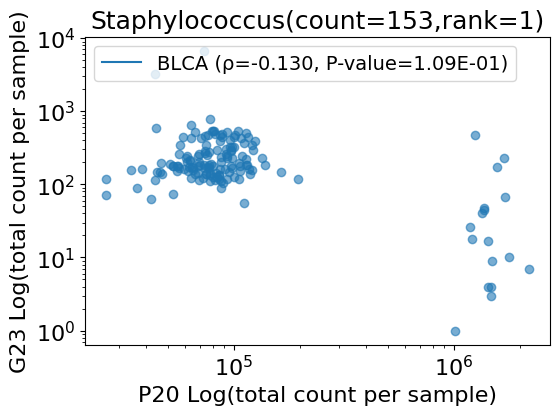

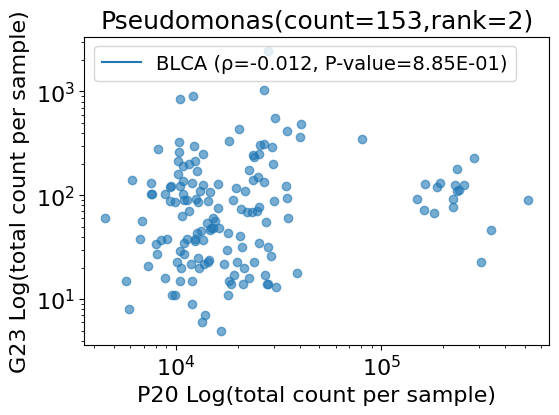

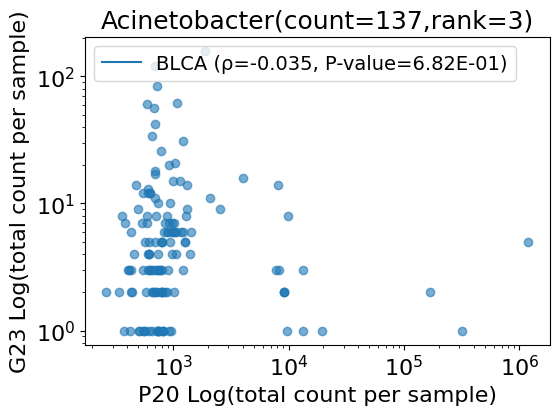

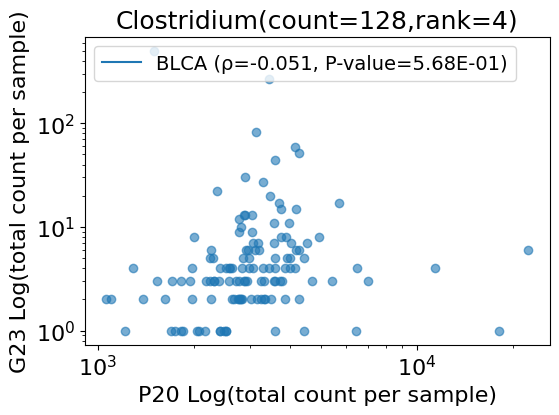

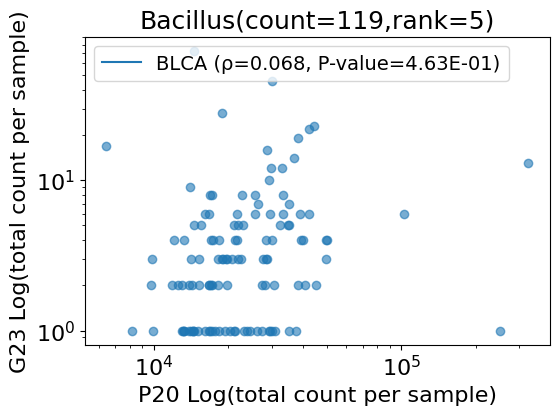

In [ ]:
for cancer_type in (['']+list(salzberg_merged_samesamples_sametaxa['investigation'].unique())):
  print(cancer_type)
  plotting.top_5_fungi_per_cancer(poore_2022_wisoverlap_merged_sampesamples_sametaxa,salzberg_merged_samesamples_sametaxa,cancer_type, all_together_same_taxa,colors,"NH22", "G23")
  plotting.top_5_fungi_per_cancer(poore_2020_merged_sampesamples_sametaxa,salzberg_merged_samesamples_sametaxa,cancer_type, all_together_same_taxa,colors,"P20", "G23")

In [ ]:
# @title
#relative abundance
salzberg_rel_abundance = utils.calculate_relative_abundance(salzberg_merged_samesamples_sametaxa, all_together_same_taxa)
poore_rel_abundance = utils.calculate_relative_abundance(poore_2022_wisoverlap_merged_sampesamples_sametaxa, all_together_same_taxa)

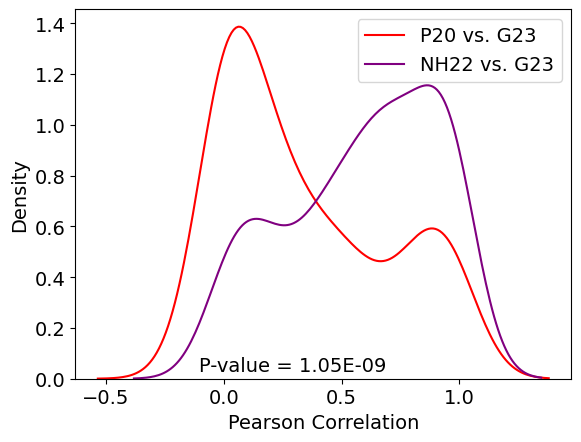

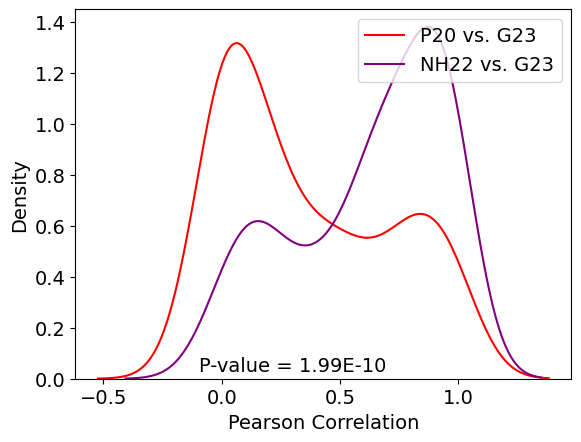

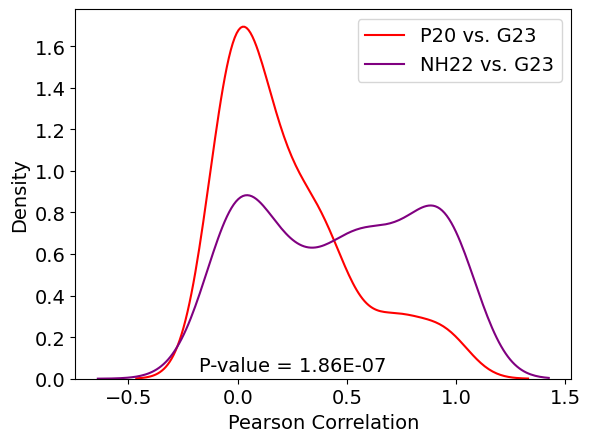

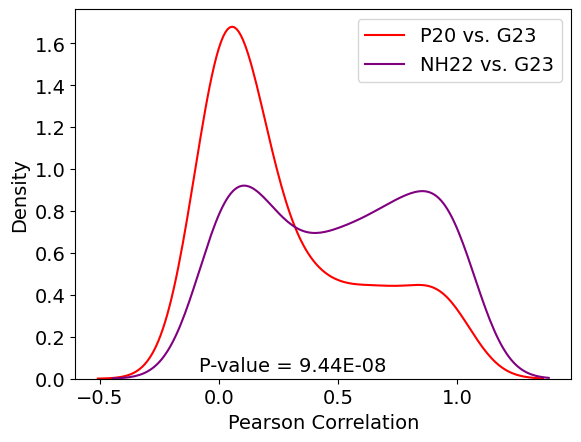

In [ ]:
#generate correlation table
c_merged = utils.generate_full_species_corr_table(salzberg_merged_samesamples_sametaxa,poore_2022_wisoverlap_merged_sampesamples_sametaxa,poore_2020_merged_sampesamples_sametaxa,all_together_same_taxa)
c_merged.to_csv(f'{res_path}/sup_table_2_species_correlation.csv')

# compare dist. of correlations
# All cancers
nan_mask = ((~c_merged.corr_P20_G23.isna()) & (~c_merged.corr_NH22_G23.isna()))
plotting.pearson_ind_corellations(c_merged.corr_P20_G23[nan_mask],c_merged.corr_NH22_G23[nan_mask])

#HNSC
nan_mask = ((~c_merged.corr_P20_G23_HNSC.isna()) & (~c_merged.corr_NH22_G23_HNSC.isna()))
plotting.pearson_ind_corellations(c_merged.corr_P20_G23_HNSC[nan_mask],c_merged.corr_NH22_G23_HNSC[nan_mask])

#BLCA
nan_mask = ((~c_merged.corr_P20_G23_BLCA.isna()) & (~c_merged.corr_NH22_G23_BLCA.isna()))
plotting.pearson_ind_corellations(c_merged.corr_P20_G23_BLCA[nan_mask],c_merged.corr_NH22_G23_BLCA[nan_mask])

#BRCA
nan_mask = ((~c_merged.corr_P20_G23_BRCA.isna()) & (~c_merged.corr_NH22_G23_BRCA.isna()))
plotting.pearson_ind_corellations(c_merged.corr_P20_G23_BRCA[nan_mask],c_merged.corr_NH22_G23_BRCA[nan_mask])

In [ ]:
comparisons_dict = {
    'race_w_b': ['WHITE','BLACK OR AFRICAN AMERICAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'race_w_a': ['WHITE','ASIAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'race_b_a': ['BLACK OR AFRICAN AMERICAN','ASIAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'gender': ['MALE','FEMALE',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label","race" ,"stage_numbered"],'gender'],
    'over_65': [1,0,["gender", "over_65", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label","race" ,"stage_numbered"],'over_65'],
    'obese': [1,0,["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered",'obese'], ["histological_diagnosis_label","race" ,"stage_numbered"],'obese']
}


df_raw = dataframes['poore_2022_raw_fungi_counts']
df_nromalized = dataframes['poore_fungi_voom_snm']

fungi_ids = dataframes['poore_2022_fungi_species']
meta_data = pd.read_table(f'{root_path}/files_for_fungi_analysis/metadata_fungi_14495samples.tsv')
meta_data = load_data.add_bmi_and_obesity_cols(meta_data, dataframes)


meta_data = load_data.compute_over_65(meta_data)
#meta_data.loc[(~meta_data['age_at_diagnosis'].isna()), 'over_65'] = (meta_data["age_at_diagnosis"] > 65).astype(int)


df_raw = df_raw.rename(columns={'Sample':'sampleid'})
df_nromalized = df_nromalized.rename(columns={'Sample':'sampleid'})

# merge raw data and metadata
df_raw_with_cancer = df_raw.merge(meta_data[['sampleid','investigation','sample_type','experimental_strategy']], on='sampleid')
df_nromalized_with_cancer = df_nromalized.merge(meta_data[['sampleid','investigation','sample_type','experimental_strategy']], on='sampleid')

experimental_strategy_name = 'RNA-Seq'
sample_type_name = 'Primary Tumor'


In [ ]:
# @title
res = utils.calculate_p_values_per_factor_total_counts(df_raw,meta_data,res_path,comparisons_dict,raw_fungi_for_analysis)
display(res)

res_anova = utils.calculate_p_values_per_factor_total_counts_anova(df_raw,meta_data,res_path,raw_fungi_for_analysis)
display(res_anova)

In [ ]:
specie_name = 's__Ramularia collo-cygni'  #'s__Phycomyces blakesleeanus' ##  #
cancer_name = 'TCGA-KIRP'  # 'TCGA-PRAD' #
threshold = 17.3605
genome_id = fungi_ids[fungi_ids.Species == specie_name]['genomeID']

only_rna_seq = False #False
pos_class =  'Primary Tumor' #'Solid Tissue Normal'

font_size = None
plotting.bar_plot_per_cancer_type(df_nromalized_with_cancer,cancer_name,genome_id,False,experimental_strategy_name,font_size)

read_counts_per_genous = df_raw_with_cancer[(df_raw_with_cancer.investigation == cancer_name)][['sampleid','experimental_strategy','sample_type',genome_id.values[0]]].sort_values(by=genome_id.values[0], ascending=False)
print('Number of reads per sample')
print(read_counts_per_genous[read_counts_per_genous.sample_type.isin(['Primary Tumor','Solid Tissue Normal'])][genome_id.values[0]].value_counts())
print(threshold)
conteg_df = utils.extract_ppv_per_threshold(df_nromalized_with_cancer,cancer_name,only_rna_seq,pos_class,genome_id,threshold)
display(conteg_df)


No. Solid Tissue Normal Samples:  unique_values    504.401
counts            36.000
dtype: float64
No. Primary Tumor Samples:  unique_values    1274.7456
counts            309.0000
dtype: float64


Number of reads per sample
G900074925
0    344
1      1
Name: count, dtype: int64
17.3605
Total Samples= 345
PPV= 95.65 %
Sensitivity= 49.84 %
Error Rate (FP+FN)= 46.96 %


G900074925  tot False  tot True
0       False         29       155
1        True          7       154

In [ ]:

specie_name = 's__Parastagonospora nodorum'  #'s__Phycomyces blakesleeanus' ##  #
cancer_name = 'TCGA-PRAD'  # 'TCGA-PRAD' #
threshold = 12.4564
genome_id = fungi_ids[fungi_ids.Species == specie_name]['genomeID']

only_rna_seq = False #False
pos_class =  'Primary Tumor' #'Solid Tissue Normal'

font_size = None
plotting.bar_plot_per_cancer_type(df_nromalized_with_cancer,cancer_name,genome_id,False,experimental_strategy_name,font_size)


read_counts_per_genous = df_raw_with_cancer[(df_raw_with_cancer.investigation == cancer_name)][['sampleid','experimental_strategy','sample_type',genome_id.values[0]]].sort_values(by=genome_id.values[0], ascending=False)
print('Number of reads per sample')
print(read_counts_per_genous[read_counts_per_genous.sample_type.isin(['Primary Tumor','Solid Tissue Normal'])][genome_id.values[0]].value_counts())
print(threshold)
conteg_df = utils.extract_ppv_per_threshold(df_nromalized_with_cancer,cancer_name,only_rna_seq,pos_class,genome_id,threshold)
display(conteg_df)


No. Solid Tissue Normal Samples:  unique_values    485.653
counts            66.000
dtype: float64
No. Primary Tumor Samples:  unique_values    1123.8591
counts            600.0000
dtype: float64


Number of reads per sample
G000146915
0    665
1      1
Name: count, dtype: int64
12.4564
Total Samples= 666
PPV= 94.59 %
Sensitivity= 55.33 %
Error Rate (FP+FN)= 43.09 %


G000146915  tot False  tot True
0       False         47       268
1        True         19       332


## 2-Evaluate Adjusted data

In [ ]:
from sklearn.linear_model import LogisticRegression

#Paramertes for all analysis:
cancer_types = dataframes["poore_2022_raw_fungi_counts_merged"]['investigation'].unique()
num_cancer_types = len(cancer_types)
color_palette = sns.color_palette("tab20", n_colors=num_cancer_types)
color_mapping = dict(zip(cancer_types, color_palette))
fungi_cols = dataframes["poore_2022_raw_fungi_counts"].columns[1:]
cohort_definition = 'iptw'
#batch_corr_dataframes = load_data.load_batch_corrected_files(dataframes, root_path,specimen_type,cohort_definition)

fungi_ids = dataframes['poore_2022_fungi_species']
fungi_cols_WGS = fungi_cols[~(fungi_cols == 'G000277815')]

comparisons_dict = {
    'race_w_b': ['WHITE','BLACK OR AFRICAN AMERICAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'race_w_a': ['WHITE','ASIAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'race_b_a': ['BLACK OR AFRICAN AMERICAN','ASIAN',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label", "stage_numbered"],'race'],
    'gender': ['MALE','FEMALE',["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label","race" ,"stage_numbered"],'gender'],
    'over_65': [1,0,["gender", "over_65", "race", "histological_diagnosis_label", "stage_numbered"], ["histological_diagnosis_label","race" ,"stage_numbered"],'over_65'],
    'obese': [1,0,["gender", "age_at_diagnosis", "race", "histological_diagnosis_label", "stage_numbered",'obese'], ["histological_diagnosis_label","race" ,"stage_numbered"],'obese']
}

iptw.generate_p_values_per_batch_corrected_normalize_pair(comparisons_dict,dataframes,root_path,res_path,fungi_cols_WGS,fungi_cols)

iptw.extract_sig_species('RNA-Seq','iptw',dataframes,root_path,res_path,comparisons_dict)

RNA-Seq_iptw - generation of p-values
generate batch corrected and normalized file using relative_abundance_bmc
generate batch corrected and normalized file using relative_abundance_combat
generate batch corrected and normalized file using relative_abundance_mmuphin
generate batch corrected and normalized file using relative_abundance_plsda
generate batch corrected and normalized file using clr_c_bmc
generate batch corrected and normalized file using clr_c_combat
generate batch corrected and normalized file using clr_c_mmuphin
generate batch corrected and normalized file using clr_c_plsda
generate batch corrected and normalized file using clr_offset_bmc
generate batch corrected and normalized file using clr_offset_combat
generate batch corrected and normalized file using clr_offset_mmuphin
generate batch corrected and normalized file using clr_offset_plsda
generate batch corrected and normalized file using log_cpm_quantile_bmc
generate batch corrected and normalized file using log_cpm_

'p-values counts were extracted'